In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import pandas as pd
from pathlib import Path

In [2]:
def xr_read_geotif(geotif_file_path, masked=True):
    da = rioxarray.open_rasterio(geotif_file_path, masked=masked)
    # If single band, squeeze to 2D; if multi-band, keep as-is and name bands
    if "band" in da.dims and da.sizes["band"] == 1:
        da = da.squeeze("band", drop=True)
        return da
    # multi-band to dataset
    ds = xr.Dataset()
    for i, v in enumerate(da.band.values):
        ds[f"band{i+1}"] = da.sel(band=v).drop_vars("band")
    return ds

def _parse_dates_from_name(path_str):
    # Expects .../HLSYYYY-MM-DD_YYYY-MM-DD...tif
    name = Path(path_str).name
    # your original slice: [3:24] -> 'YYYY-MM-DD_YYYY-MM-DD'
    dates = name[3:24]
    start_date = datetime.strptime(dates[:10], "%Y-%m-%d")
    end_date   = datetime.strptime(dates[11:], "%Y-%m-%d")
    return dates, start_date, end_date, (end_date - start_date)

def _ds_from_file(path, varname):
    dates, start_date, end_date, t_baseline = _parse_dates_from_name(path)

    da = xr_read_geotif(path, masked=False)
    # If xr_read_geotif returned a DataArray (single band), name it
    if isinstance(da, xr.DataArray):
        da = da.rename(varname).to_dataset()
    else:
        # If multi-band, assume band1 is desired (adapt if needed)
        da = da.rename({"band1": varname})[[varname]]

    # add coords and expand dates dimension
    ds = da.assign_coords({"dates": dates}).expand_dims("dates")
    ds = ds.assign_coords(
        start_date=("dates", [start_date]),
        end_date=("dates", [end_date]),
        t_baseline=("dates", [t_baseline]),
    )
    return ds

def combine_veloc(data_dir):
    # Collect both x and y files
    xs = sorted(glob(f"{data_dir}/*/S2*veloc_x.tif"))
    ys = sorted(glob(f"{data_dir}/*/S2*veloc_y.tif"))

    # Build datasets for each, keyed by the dates token, so we can inner-join pairs
    x_ds_by_key = {}
    for p in xs:
        key, *_ = _parse_dates_from_name(p)
        x_ds_by_key[key] = _ds_from_file(p, "veloc_ew")  # x -> east-west

    y_ds_by_key = {}
    for p in ys:
        key, *_ = _parse_dates_from_name(p)
        y_ds_by_key[key] = _ds_from_file(p, "veloc_ns")  # y -> north-south

    # Only keep keys that exist in both sets (inner join on dates)
    common = sorted(set(x_ds_by_key).intersection(y_ds_by_key))

    if not common:
        raise ValueError("No matching veloc_x / veloc_y date pairs found.")

    # Merge per-pair, then concat across dates
    pairs = []
    for k in common:
        # Coordinates (start_date, end_date, t_baseline, dates) match by construction
        merged = xr.merge([x_ds_by_key[k], y_ds_by_key[k]], compat="identical")
        pairs.append(merged)

    ds = xr.concat(pairs, dim="dates", combine_attrs="no_conflicts").sortby("dates")

    # Carry CRS/geotransform if present
    for v in ["veloc_ew", "veloc_ns"]:
        if hasattr(ds[v], "rio"):
            try:
                ds = ds.rio.write_crs(ds[v].rio.crs or ds.rio.crs, inplace=True)
            except Exception:
                pass  # ignore if CRS handling isn't applicable

    return ds

In [16]:
ds = combine_veloc('../data/JJA_S2')

In [19]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:      (dates: 110, y: 1787, x: 1665)
Coordinates:
  * x            (x) float64 13kB 5.873e+05 5.873e+05 ... 6.039e+05 6.039e+05
  * y            (y) float64 14kB 5.2e+06 5.2e+06 ... 5.182e+06 5.182e+06
  * dates        (dates) <U21 9kB '2017-07-02_2017-07-17' ... '2025-06-30_202...
    start_date   (dates) datetime64[ns] 880B 2017-07-02 ... 2025-06-30
    end_date     (dates) datetime64[ns] 880B 2017-07-17 ... 2025-08-21
    t_baseline   (dates) timedelta64[ns] 880B 15 days 20 days ... 52 days
    spatial_ref  int64 8B 0
Data variables:
    veloc_ew     (dates, y, x) float64 3GB nan nan nan nan ... nan nan nan nan
    veloc_ns     (dates, y, x) float64 3GB nan nan nan nan ... nan nan nan nan

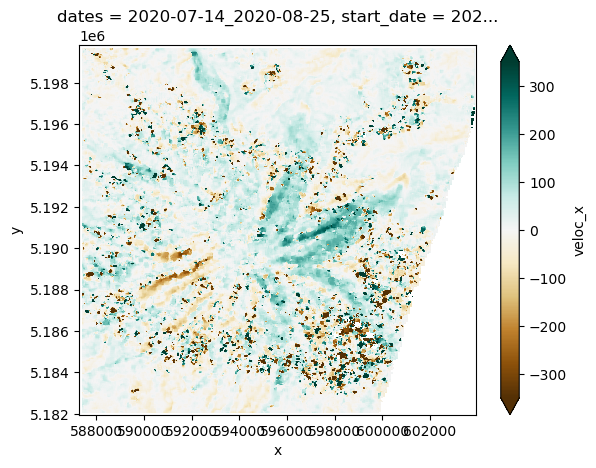

In [13]:
ds.isel(dates=7).veloc_ew.plot.imshow(vmin= -350, vmax=350, cmap='BrBG')

In [17]:
median_ew = ds.veloc_ew.median(dim='dates')

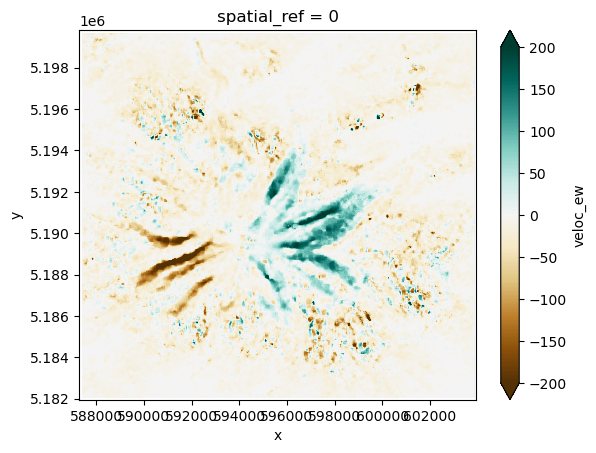

In [18]:
(median_ew).plot.imshow(vmin= -200, vmax=200, cmap='BrBG')